In [1]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("milapgohil/play-tennis-dataset-weather-based-classifier")

#print("Path to dataset files:", path)
# Copy insurance.csv to the current directory
try:
  shutil.copy(path + "/play_tennis_dataset.csv", os.getcwd())
except shutil.Error as e:
  print("Cannot copy file: {}".format(e))

# Open dataset to dataframe before analysis, for example:
# import pandas as pd
# df = pd.read_csv("play_tennis_dataset.csv")

100%|██████████| 20.6k/20.6k [00:00<00:00, 17.6MB/s]

Extracting files...


Data setelah one-hot encoding:
   Outlook_Overcast  Outlook_Rainy  Outlook_Sunny  Temperature_Cool  \
0              True          False          False             False   
1             False          False           True             False   
2             False          False          False             False   
3             False          False           True             False   
4             False          False           True              True   

   Temperature_Hot  Temperature_Mild  Humidity_High  Humidity_Normal  \
0            False              True          False             True   
1            False              True          False             True   
2            False              True           True            False   
3            False              True           True            False   
4            False             False          False             True   

   Wind_Strong  Wind_Weak  
0         True      False  
1         True      False  
2         True      False

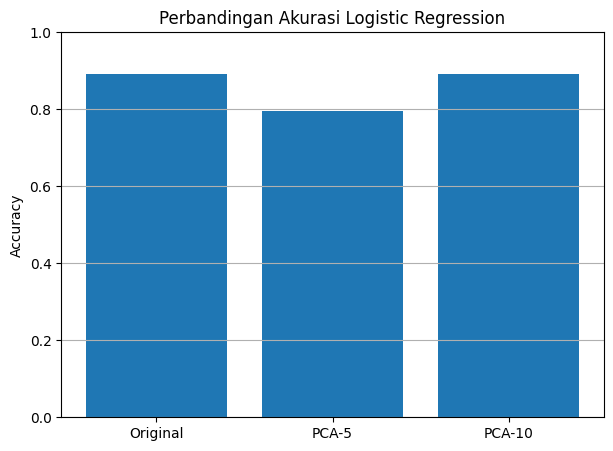

In [16]:
# ==========================================================
#  PCA + Logistic Regression Training (Original, PCA-5, PCA-10)
# ==========================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ==========================================================
# 1. Load dataset
# ==========================================================
df = pd.read_csv("/content/play_tennis_dataset(1).csv")  # sesuaikan path

# Tentukan target (kolom terakhir)
target_col = df.columns[-1]
y = df[target_col]

# ==========================================================
# 2. One-Hot Encoding untuk SEMUA fitur kategorikal
#    (tanpa LabelEncoder sama sekali)
# ==========================================================
X = pd.get_dummies(df.drop(columns=[target_col]), drop_first=False)

print("Data setelah one-hot encoding:")
print(X.head())
print("Jumlah fitur:", X.shape[1])

# ==========================================================
# 3. Train-test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ==========================================================
# 4. Normalisasi wajib sebelum PCA
# ==========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================================
# 5. PCA TRAINING UNTUK 10 KOMPONEN
# ==========================================================
pca = PCA(n_components=10)  # jumlah fitur sudah mencukupi sekarang
pca.fit(X_train_scaled)

print("\nExplained variance ratio (10 PC):")
print(pca.explained_variance_ratio_)
print("Cumulative explained variance:")
print(np.cumsum(pca.explained_variance_ratio_))

# Transform data
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ==========================================================
# 6. Logistic Regression Training
# ==========================================================
results = {}

# ORIGINAL
model_org = LogisticRegression(max_iter=2000, solver="liblinear")
model_org.fit(X_train_scaled, y_train)
acc_org = accuracy_score(y_test, model_org.predict(X_test_scaled))
results["original"] = acc_org
print("\nAccuracy ORIGINAL:", acc_org)

# PCA TOP 5
model_p5 = LogisticRegression(max_iter=2000, solver="liblinear")
model_p5.fit(X_train_pca[:, :5], y_train)
acc_p5 = accuracy_score(y_test, model_p5.predict(X_test_pca[:, :5]))
results["pca5"] = acc_p5
print("Accuracy PCA-5:", acc_p5)

# PCA TOP 10
model_p10 = LogisticRegression(max_iter=2000, solver="liblinear")
model_p10.fit(X_train_pca[:, :10], y_train)
acc_p10 = accuracy_score(y_test, model_p10.predict(X_test_pca[:, :10]))
results["pca10"] = acc_p10
print("Accuracy PCA-10:", acc_p10)

# ==========================================================
# 7. Ringkasan hasil
# ==========================================================
print("\n=== RINGKASAN AKURASI ===")
for mode, acc in results.items():
    print(f"{mode:10s} : {acc:.4f}")

# ==========================================================
# 8. Grafik Perbandingan Akurasi
# ==========================================================
plt.figure(figsize=(7,5))
plt.bar(["Original", "PCA-5", "PCA-10"], [acc_org, acc_p5, acc_p10])
plt.title("Perbandingan Akurasi Logistic Regression")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()


/tmp/ipython-input-3244602638.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_plot = y_train.replace({"No": 0, "Yes": 1}).values


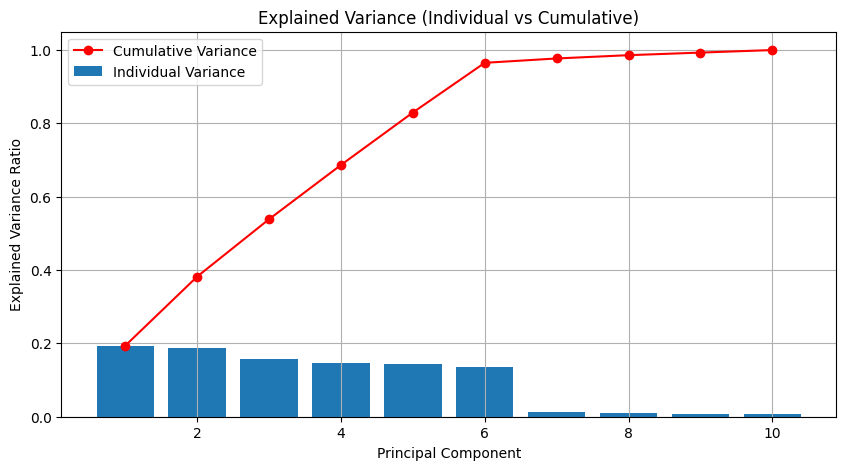

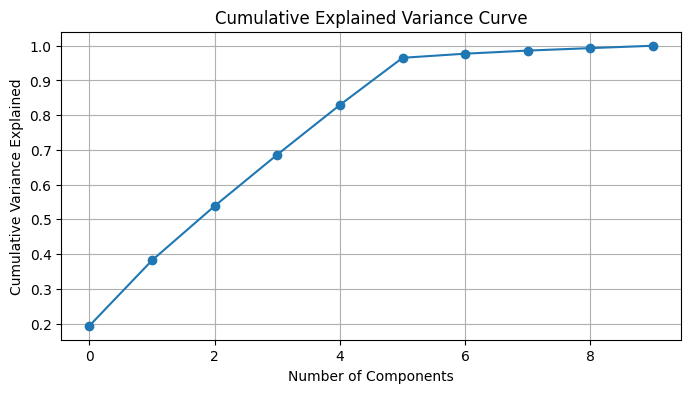

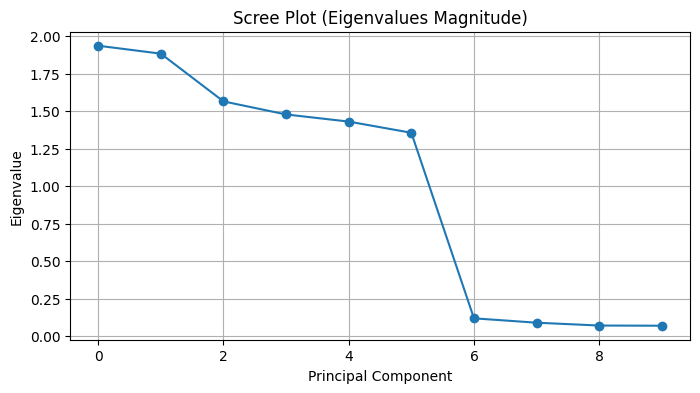

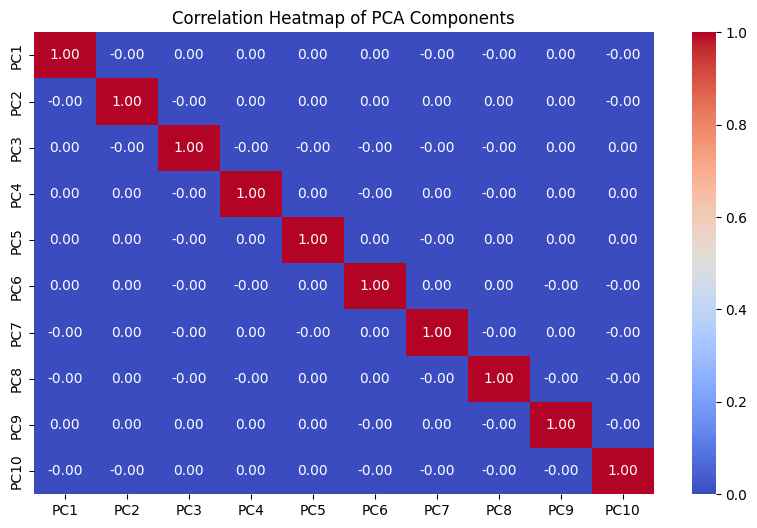

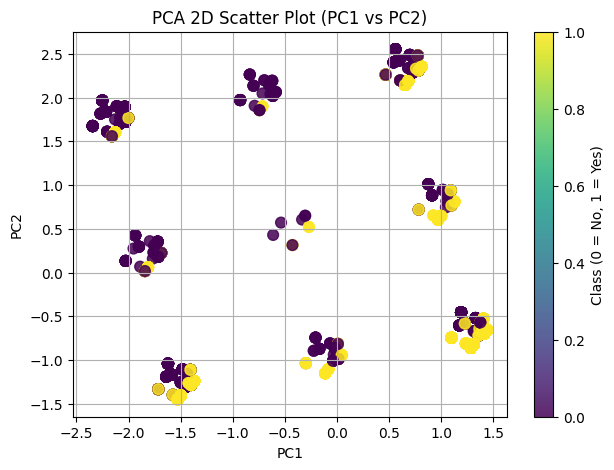

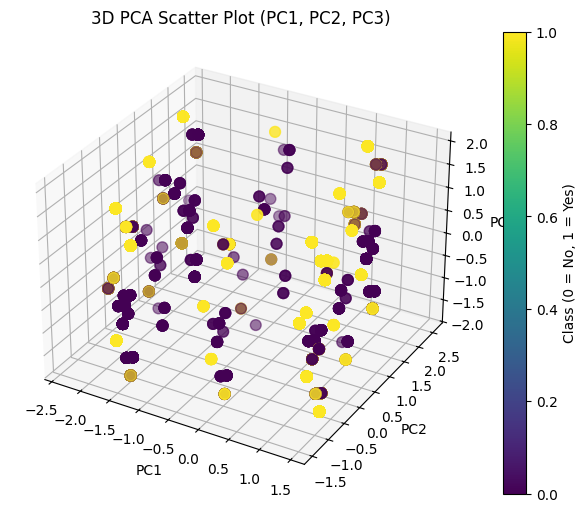

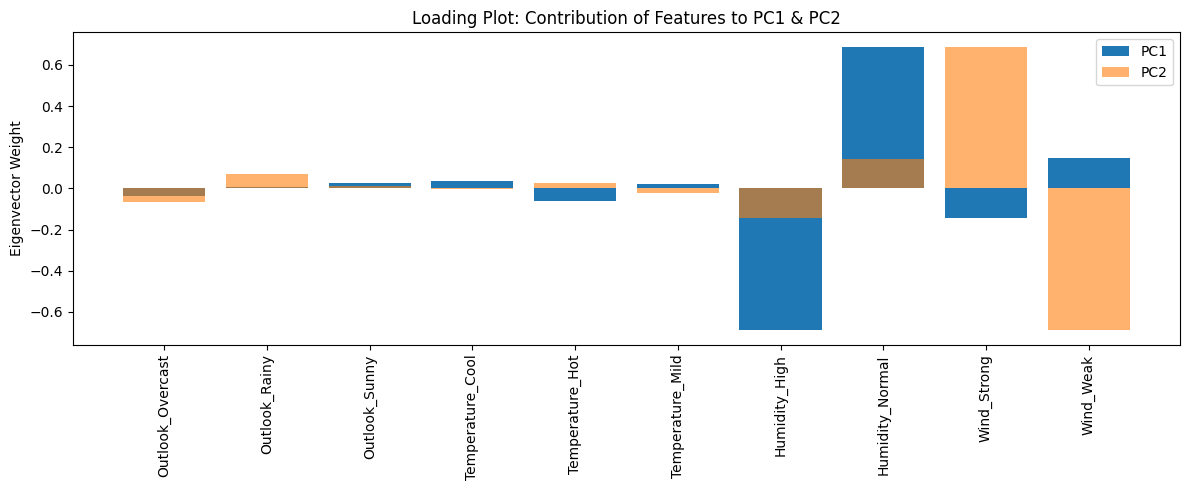

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# ==========================================================
# 0. Convert target ke numeric untuk plotting
# ==========================================================
y_plot = y_train.replace({"No": 0, "Yes": 1}).values
# Jika target sudah numeric, hilangkan line di atas.

# ==========================================================
# 1. Individual & Cumulative Explained Variance
# ==========================================================
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
        pca.explained_variance_ratio_,
        label='Individual Variance')

plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_),
         marker='o', color='red',
         label='Cumulative Variance')

plt.title("Explained Variance (Individual vs Cumulative)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================================
# 2. Cumulative Explained Variance Curve
# ==========================================================
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance Curve")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

# ==========================================================
# 3. Scree Plot (Eigenvalues)
# ==========================================================
plt.figure(figsize=(8,4))
plt.plot(pca.explained_variance_, marker='o')
plt.title("Scree Plot (Eigenvalues Magnitude)")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

# ==========================================================
# 4. Heatmap Korelasi Antar Principal Components
# ==========================================================
pc_df = pd.DataFrame(X_train_pca[:, :10], columns=[f"PC{i+1}" for i in range(10)])

plt.figure(figsize=(10,6))
sns.heatmap(pc_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of PCA Components")
plt.show()

# ==========================================================
# 5. PCA Scatter Plot 2D (PC1 vs PC2)
# ==========================================================
plt.figure(figsize=(7,5))
plt.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    c=y_plot,
    cmap="viridis",
    s=60,
    alpha=0.85
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Scatter Plot (PC1 vs PC2)")
plt.grid(True)
plt.colorbar(label="Class (0 = No, 1 = Yes)")
plt.show()

# ==========================================================
# 6. PCA Scatter Plot 3D (PC1, PC2, PC3)
# ==========================================================
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    X_train_pca[:,2],
    c=y_plot,
    cmap='viridis',
    s=60
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Scatter Plot (PC1, PC2, PC3)")
plt.colorbar(sc, label="Class (0 = No, 1 = Yes)")
plt.show()

# ==========================================================
# 7. Loading Plot – Eigenvector PC1 & PC2
# ==========================================================
loading_matrix = pca.components_.T  # eigenvectors

plt.figure(figsize=(12,5))
plt.bar(range(len(X.columns)), loading_matrix[:,0], label="PC1")
plt.bar(range(len(X.columns)), loading_matrix[:,1], alpha=0.6, label="PC2")

plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.title("Loading Plot: Contribution of Features to PC1 & PC2")
plt.ylabel("Eigenvector Weight")
plt.legend()
plt.tight_layout()
plt.show()
